<a href="https://colab.research.google.com/github/Rajsoni03/DeMe-Net/blob/main/DeMe_Net.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Importing Libraries

In [1]:
#import the important libraries

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image
import pandas as pd
import datetime
import tensorflow as tf
import os
import shutil

from tensorflow.keras.utils import plot_model
from keras.preprocessing.image import ImageDataGenerator
from keras.preprocessing.image import array_to_img, img_to_array
from tensorflow.keras.models import Sequential, Model, load_model
from tensorflow.keras.layers import Conv2D, Flatten, BatchNormalization, Dropout, Dense, MaxPool2D, Input, Concatenate, MaxPooling2D
from keras.callbacks import ReduceLROnPlateau
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report

# Clone Data from Kaggle

In [2]:
# os.environ['KAGGLE_CONFIG_DIR'] = '/content/drive/MyDrive/AI Colab/Kaggle'

# !kaggle competitions download --force -c siim-isic-melanoma-classification -f train.csv
# !kaggle datasets download -d sarques/siic-melanoma-384x384-test

# !kaggle datasets download -d kmader/skin-cancer-mnist-ham10000 -f hmnist_28_28_RGB.csv.csv

In [3]:
# !unzip /content/siic-melanoma-384x384-test.zip && rm /content/siic-melanoma-384x384-test.zip

# !unzip /content/skin-cancer-mnist-ham10000.zip && rm /content/skin-cancer-mnist-ham10000.zip

In [4]:
shutil.copy('/content/drive/MyDrive/Colab Notebooks/Skin Disease Classification/data/hmnist_28_28_RGB.csv.zip', '/content')
!unzip hmnist_28_28_RGB.csv.zip

Archive:  hmnist_28_28_RGB.csv.zip
  inflating: hmnist_28_28_RGB.csv    


# Prepair Data

In [5]:
# Load image data

df = pd.read_csv('/content/hmnist_28_28_RGB.csv')
df.shape

(10015, 2353)

In [6]:
# Randomly suffle images

df = df.sample(frac = 1)
df.head(5)

,pixel0000,pixel0001,pixel0002,pixel0003,pixel0004,pixel0005,pixel0006,pixel0007,pixel0008,pixel0009,pixel0010,pixel0011,pixel0012,pixel0013,pixel0014,pixel0015,pixel0016,pixel0017,pixel0018,pixel0019,pixel0020,pixel0021,pixel0022,pixel0023,pixel0024,pixel0025,pixel0026,pixel0027,pixel0028,pixel0029,pixel0030,pixel0031,pixel0032,pixel0033,pixel0034,pixel0035,pixel0036,pixel0037,pixel0038,pixel0039,...,pixel2313,pixel2314,pixel2315,pixel2316,pixel2317,pixel2318,pixel2319,pixel2320,pixel2321,pixel2322,pixel2323,pixel2324,pixel2325,pixel2326,pixel2327,pixel2328,pixel2329,pixel2330,pixel2331,pixel2332,pixel2333,pixel2334,pixel2335,pixel2336,pixel2337,pixel2338,pixel2339,pixel2340,pixel2341,pixel2342,pixel2343,pixel2344,pixel2345,pixel2346,pixel2347,pixel2348,pixel2349,pixel2350,pixel2351,label
2500,195,172,183,195,172,184,196,174,186,197,176,185,200,178,189,199,177,188,202,179,191,202,180,191,203,181,194,206,186,198,206,186,199,207,185,197,206,183,196,205,...,204,183,193,205,184,195,207,186,197,206,185,196,204,182,193,203,181,192,201,178,190,200,178,187,198,175,185,199,178,189,199,177,189,198,176,186,199,178,188,1
7145,216,206,212,217,205,210,217,206,212,218,207,216,218,206,217,218,205,215,217,205,213,217,204,213,218,206,215,217,205,213,217,205,213,218,208,218,220,210,221,220,...,218,206,215,217,207,215,217,208,216,219,211,219,217,208,214,217,206,215,217,206,214,217,205,214,217,206,217,217,208,218,218,205,218,216,203,214,214,201,210,4
9422,194,171,164,210,187,176,219,199,186,223,202,189,223,204,193,224,205,196,224,204,193,225,206,195,226,209,203,227,212,208,228,212,208,227,209,204,225,206,201,222,...,227,208,201,224,200,189,224,200,192,223,198,187,223,197,190,224,199,196,225,203,197,224,203,195,221,200,193,222,202,192,222,204,197,219,200,191,209,184,169,4
3739,217,144,134,220,146,140,224,152,144,221,146,136,225,150,146,225,148,147,224,148,141,232,157,153,231,160,156,233,163,159,229,156,151,233,163,161,232,160,157,228,...,201,112,119,196,105,115,199,114,124,198,111,120,198,113,122,198,112,120,196,104,112,196,106,112,193,99,103,190,96,99,188,100,107,184,101,111,180,97,103,4
8893,147,113,117,158,128,130,161,131,132,172,144,147,178,149,152,182,154,159,186,160,165,187,160,165,189,162,167,192,166,171,193,166,171,191,166,171,191,167,171,190,...,188,161,163,185,155,155,184,154,155,181,150,152,181,150,153,181,151,154,178,150,153,174,143,145,167,135,134,163,131,131,161,129,131,155,124,124,144,111,110,4


In [7]:
# crop image pixles from DataFrame

data = df.iloc[:,:-1]
data.shape

(10015, 2352)

In [8]:
# crop labels from DataFrame

labels = df.iloc[:,-1:]
labels.shape

(10015, 1)

akiec : 327
bcc : 514
bkl : 1099
df : 115
nv : 6705
vasc : 142
mel : 1113


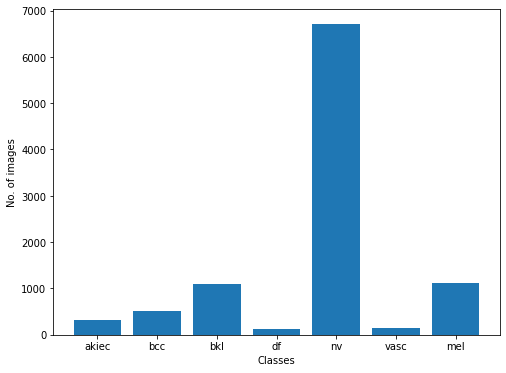

In [9]:
# Plot Bar Chart for Image Type Count
type_of_cancer = {0 : 'akiec',
                  1 : 'bcc',
                  2 : 'bkl',
                  3 : 'df',
                  4 : 'nv',
                  5 : 'vasc',
                  6 : 'mel'}

labels_count = dict()
for i in type_of_cancer.keys():
  labels_count[type_of_cancer[i]] = len(df[df['label'] == i])
  print(type_of_cancer[i], ':', len(df[df['label'] == i]))

plt.figure(figsize = (8,6))
plt.bar(labels_count.keys(), labels_count.values())
plt.ylabel('No. of images')
plt.xlabel('Classes')
plt.show()

# Handle Class Unbalance Problem

In [10]:
# Duplicate data for balance the classes

df = df.sort_values('label')
df = df.reset_index()


index0 = df[df['label'] == 0].index.values
index1 = df[df['label'] == 1].index.values
index2 = df[df['label'] == 2].index.values
index3 = df[df['label'] == 3].index.values
index5 = df[df['label'] == 5].index.values
index6 = df[df['label'] == 6].index.values


df0 = df.iloc[int(min(index0)):int(max(index0)+1)]
df1 = df.iloc[int(min(index1)):int(max(index1)+1)]
df2 = df.iloc[int(min(index2)):int(max(index2)+1)]
df3 = df.iloc[int(min(index3)):int(max(index3)+1)]
df5 = df.iloc[int(min(index5)):int(max(index5)+1)]
df6 = df.iloc[int(min(index6)):int(max(index6)+1)]


df_index0 = df0.append([df0]*19, ignore_index = True)
df_index1 = df1.append([df1]*11, ignore_index = True)
df_index2 = df2.append([df2]*4, ignore_index = True)
df_index3 = df3.append([df3]*57, ignore_index = True)
df_index5 = df5.append([df5]*45, ignore_index = True)
df_index6 = df6.append([df6]*4, ignore_index = True)

frames = [df, df_index0, df_index1, df_index2, df_index3, df_index5, df_index6]

final_df = pd.concat(frames)
final_df.drop('index', inplace = True, axis = 1)
final_df = final_df.sample(frac = 1)
data = final_df.iloc[:,:-1]
labels = final_df.iloc[:,-1:]
print(final_df.shape)

(46985, 2353)


akiec : 6867
bcc : 6682
bkl : 6594
df : 6785
nv : 6705
vasc : 6674
mel : 6678


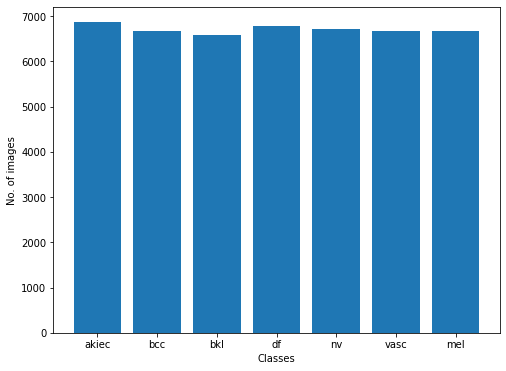

In [11]:
# Plot Bar Chart for Image Type Count

type_of_cancer = {0 : 'akiec',
                  1 : 'bcc',
                  2 : 'bkl',
                  3 : 'df',
                  4 : 'nv',
                  5 : 'vasc',
                  6 : 'mel'}

labels_count = dict()
for i in type_of_cancer.keys():
  labels_count[type_of_cancer[i]] = len(final_df[final_df['label'] == i])
  print(type_of_cancer[i], ':', len(final_df[final_df['label'] == i]))

plt.figure(figsize = (8,6))
plt.bar(labels_count.keys(), labels_count.values())
plt.ylabel('No. of images')
plt.xlabel('Classes')
plt.show()

# Data Preprocessing

In [12]:
# Convart DataFrame to numpy array

X = np.array(data)
Y = np.array(labels)

In [13]:
# convart pixles to standard (28 x 28 X 3) image

X = X.reshape(-1,28,28,3)

print( X.shape)
print( Y.shape)

(46985, 28, 28, 3)
(46985, 1)


In [14]:
# Normalize Data using 

X = (X-np.mean(X))/np.std(X)

In [15]:
# split data into Train, val, test set in ratio of 8:2

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=1)

print(X_train.shape)
print(X_test.shape)
print(Y_train.shape)
print(Y_test.shape)

(37588, 28, 28, 3)
(9397, 28, 28, 3)
(37588, 1)
(9397, 1)


In [16]:
# Image Data Augmentation 
train_datagen = ImageDataGenerator(rescale = 1./255,
                                   brightness_range = [-0.2, 0.2],
                                  rotation_range = 10,
                                  width_shift_range = 0.2,
                                  height_shift_range = 0.2,
                                  shear_range = 0.2,
                                  horizontal_flip = True,
                                  vertical_flip = True,
                                  fill_mode = 'nearest')
train_datagen.fit(X_train)

test_datagen = ImageDataGenerator(rescale = 1./255)
test_datagen.fit(X_test)

train_data = train_datagen.flow(X_train, Y_train, batch_size = 64)
test_data = test_datagen.flow(X_test, Y_test, batch_size = 64)

# Creating Model

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 28, 28, 3)]  0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 28, 28, 32)   896         input_1[0][0]                    
__________________________________________________________________________________________________
conv2d_2 (Conv2D)               (None, 28, 28, 24)   1824        input_1[0][0]                    
__________________________________________________________________________________________________
conv2d_4 (Conv2D)               (None, 28, 28, 16)   2368        input_1[0][0]                    
______________________________________________________________________________________________

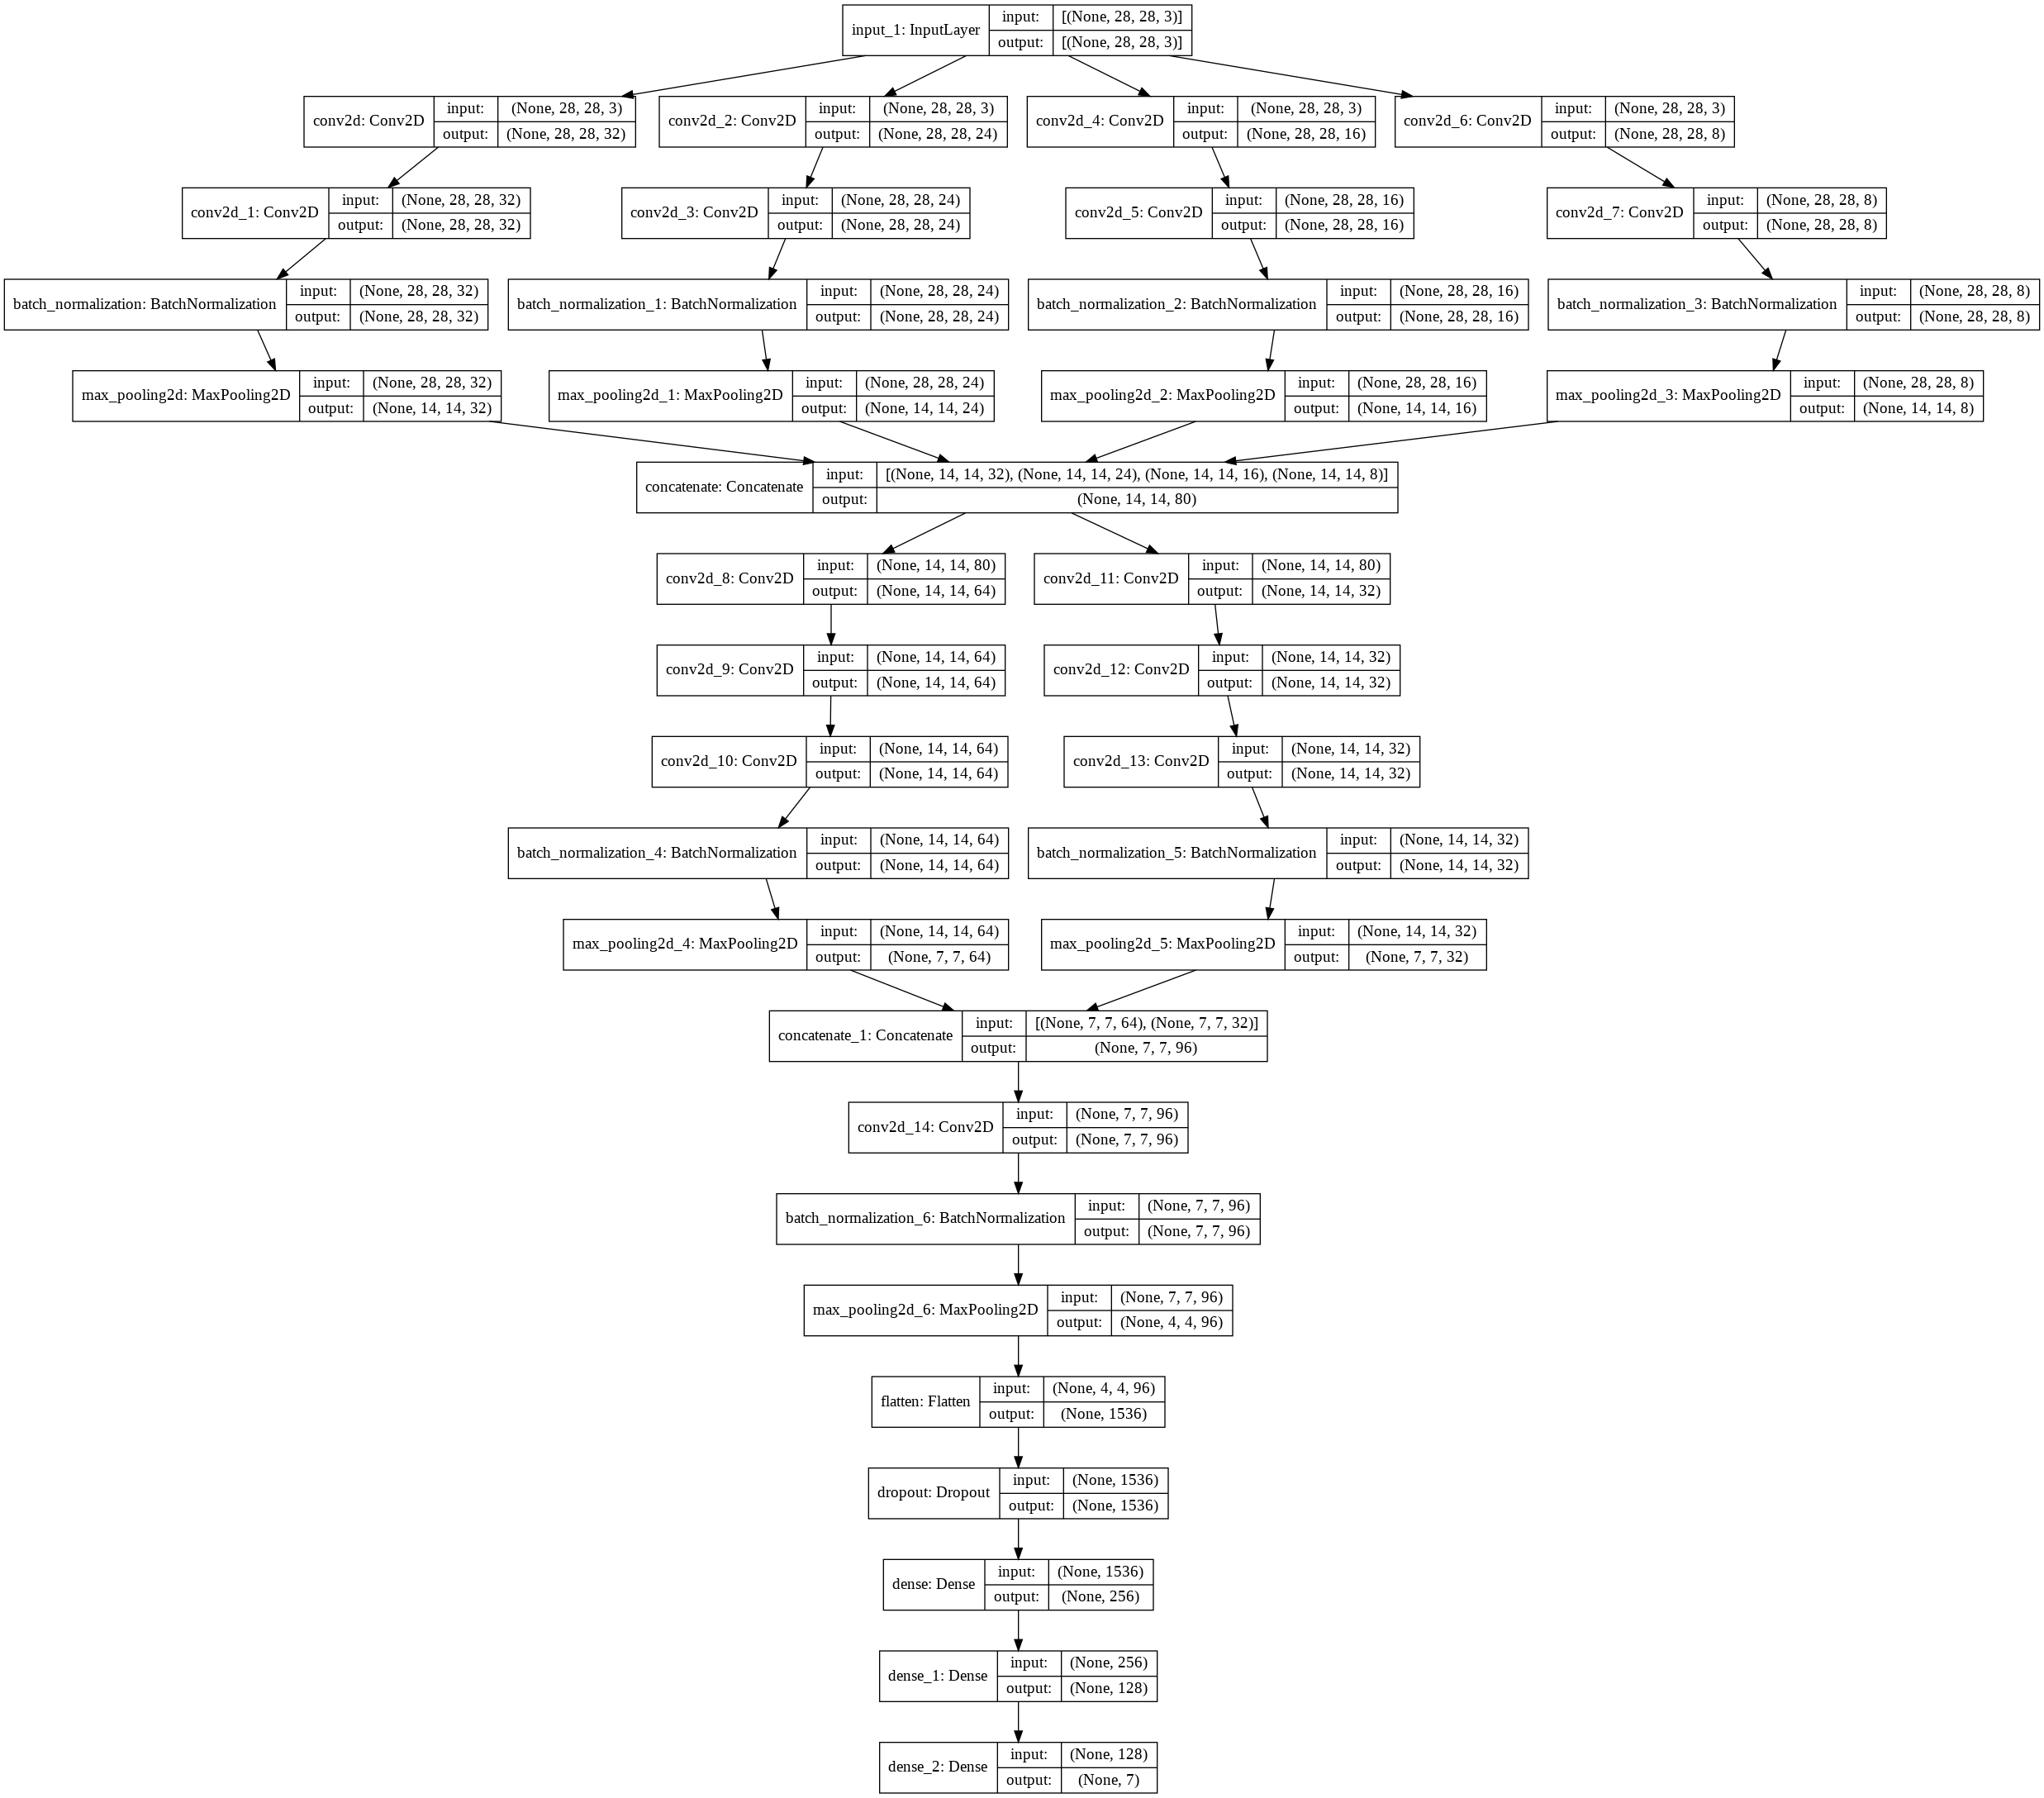

In [ ]:
Input_X = Input(shape=(28, 28, 3))

# 3x3 conv
X1 = Conv2D(32, (3,3), padding='same', activation='relu')(Input_X)
X1 = Conv2D(32, (3,3), padding='same', activation='relu')(X1)
X1 = BatchNormalization()(X1)
X1 = MaxPooling2D((2,2), padding='same')(X1)

# 5x5 conv
X2 = Conv2D(24, (5,5), padding='same', activation='relu')(Input_X)
X2 = Conv2D(24, (5,5), padding='same', activation='relu')(X2)
X2 = BatchNormalization()(X2)
X2 = MaxPooling2D((2,2), padding='same')(X2)

# 7x7 conv
X3 = Conv2D(16, (7,7), padding='same', activation='relu')(Input_X)
X3 = Conv2D(16, (7,7), padding='same', activation='relu')(X3)
X3 = BatchNormalization()(X3)
X3 = MaxPooling2D((2,2), padding='same')(X3)

# 11x11 conv
X4 = Conv2D(8, (3,3), padding='same', activation='relu')(Input_X)
X4 = Conv2D(8, (3,3), padding='same', activation='relu')(X4)
X4 = BatchNormalization()(X4)
X4 = MaxPooling2D((2,2), padding='same')(X4)

X = Concatenate(axis=-1)([X1, X2, X3, X4])

# 3x3 Conv 
X1 = Conv2D(64, (3,3), padding='same', activation='relu')(X)
X1 = Conv2D(64, (3,3), padding='same', activation='relu')(X1)
X1 = Conv2D(64, (3,3), padding='same', activation='relu')(X1)
X1 = BatchNormalization()(X1)
X1 = MaxPooling2D((2,2), padding='same')(X1)

# 5x5 Conv 
X2 = Conv2D(32, (5,5), padding='same', activation='relu')(X)
X2 = Conv2D(32, (5,5), padding='same', activation='relu')(X2)
X2 = Conv2D(32, (5,5), padding='same', activation='relu')(X2)
X2 = BatchNormalization()(X2)
X2 = MaxPooling2D((2,2), padding='same')(X2)

X = Concatenate(axis=-1)([X1, X2])

X = Conv2D(96, (3,3), padding='same', activation='relu')(X)
X = BatchNormalization()(X)
X = MaxPooling2D((2,2), padding='same')(X)

X = Flatten()(X)
X = Dropout(0.9)(X)
X = Dense(256, activation='relu')(X)
X = Dense(128, activation='relu')(X)
X = Dense(7, activation='softmax')(X)

model = Model(inputs = Input_X, outputs = X)
print(model.summary())
plot_model(model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)

# Training

In [ ]:
learning_rate_reduction = ReduceLROnPlateau(monitor='val_accuracy', 
                                            patience=2, 
                                            verbose=1, 
                                            factor=0.5, 
                                            min_lr=0.00001)

optimizer = tf.keras.optimizers.Adam(learning_rate = 0.00075,
                                     beta_1 = 0.9,
                                     beta_2 = 0.999,
                                     epsilon = 1e-8)

EPOCHS = 30

model.compile(loss='sparse_categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])

In [ ]:
history = model.fit(X_train, Y_train,
                    validation_split=0.2,
                    batch_size = 64,
                    epochs = EPOCHS,
                    callbacks=[learning_rate_reduction]) 

Epoch 1/30
470/470 [==============================] - 41s 20ms/step - loss: 1.6938 - accuracy: 0.3824 - val_loss: 1.2511 - val_accuracy: 0.5129
Epoch 2/30
470/470 [==============================] - 8s 17ms/step - loss: 1.0958 - accuracy: 0.5766 - val_loss: 1.1736 - val_accuracy: 0.5829
Epoch 3/30
470/470 [==============================] - 8s 17ms/step - loss: 0.8344 - accuracy: 0.6806 - val_loss: 0.7729 - val_accuracy: 0.7018
Epoch 4/30
470/470 [==============================] - 8s 18ms/step - loss: 0.6858 - accuracy: 0.7385 - val_loss: 0.5857 - val_accuracy: 0.7795
Epoch 5/30
470/470 [==============================] - 8s 18ms/step - loss: 0.5730 - accuracy: 0.7817 - val_loss: 0.4847 - val_accuracy: 0.8093
Epoch 6/30
470/470 [==============================] - 8s 18ms/step - loss: 0.4785 - accuracy: 0.8157 - val_loss: 0.4514 - val_accuracy: 0.8268
Epoch 7/30
470/470 [==============================] - 8s 18ms/step - loss: 0.4178 - accuracy: 0.8408 - val_loss: 0.3629 - val_accuracy: 0.853

# Evaluate the model on testing data

In [17]:
# load Model if already trained 
# model = tf.keras.models.load_model('/content/drive/MyDrive/Colab Notebooks/Skin Disease Classification/models/best_model.h5')

In [ ]:
model_acc_test = model.evaluate(X_test, Y_test, verbose=0)[1]
print("Model accuracy on test data =", model_acc_test * 100)

Model accuracy on test data = 98.3398973941803


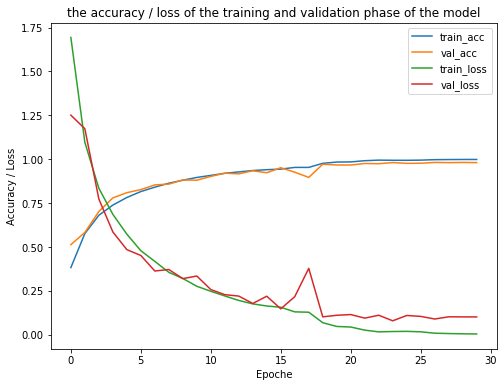

In [ ]:
ACC = history.history['accuracy']
VAL_ACC = history.history['val_accuracy']
LOSS = history.history['loss']
VAL_LOSS = history.history['val_loss']

plt.figure(figsize=(8,6))
plt.title("the accuracy / loss of the training and validation phase of the model")
plt.ylabel('Accuracy / Loss')
plt.xlabel('Epoche')
plt.plot(ACC, label = 'train_acc')
plt.plot(VAL_ACC, label = 'val_acc')
plt.plot(LOSS, label = 'train_loss')
plt.plot(VAL_LOSS, label = 'val_loss')
plt.legend()

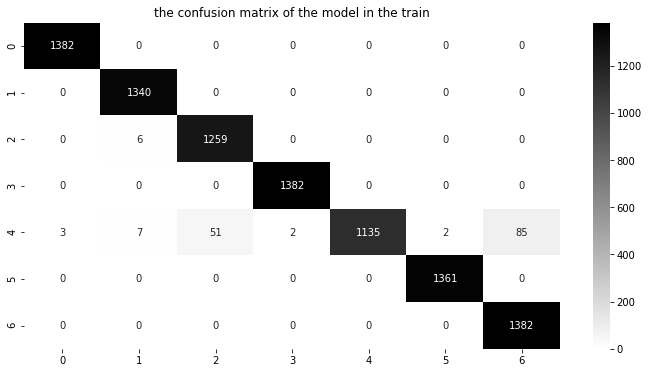

In [ ]:
Y_true = np.array([Y_test])

Y_pred = model.predict(X_test)
Y_pred = np.array(list(map(lambda x: np.argmax(x), Y_pred)))

cm1 = confusion_matrix(Y_true, Y_pred)
cm1 = pd.DataFrame(cm1, index=['akiec', 'bcc', 'bkl', 'df', 'nv', 'vasc','mel'], columns =['akiec', 'bcc', 'bkl', 'df', 'nv', 'vasc','mel'])

plt.figure(figsize=(12, 6))
# plt.title('the confusion matrix of the model in the train')
plt.figure(figsize = (10,7))
plt.xlabel('Actual Value')
plt.ylabel('Predicted Value')
sns.heatmap(cm1, annot = True, fmt = 'g' ,vmin = 0, cmap = 'binary', cbar=False)
plt.plot()

In [ ]:
classification_report_model = classification_report(Y_true, Y_pred, target_names=type_of_cancer.values())
print(classification_report_model)

              precision    recall  f1-score   support

       akiec       1.00      1.00      1.00      1382
         bcc       0.99      1.00      1.00      1340
         bkl       0.96      1.00      0.98      1265
          df       1.00      1.00      1.00      1382
          nv       1.00      0.88      0.94      1285
        vasc       1.00      1.00      1.00      1361
         mel       0.94      1.00      0.97      1382

    accuracy                           0.98      9397
   macro avg       0.98      0.98      0.98      9397
weighted avg       0.98      0.98      0.98      9397



In [ ]:
model.save('/content/drive/MyDrive/Colab Notebooks/Skin Disease Classification/models/best_model.h5')